In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

from pathlib import Path
root_path = Path.cwd().parent.parent.parent.absolute()
import sys
current_dir = Path.cwd()
repo_root = current_dir.parent.parent.parent  # Go up 3 levels
pdpo_path = str(repo_root.absolute())
# Add repository root to path
sys.path.insert(0, pdpo_path)




In [2]:
import jax
import jax.numpy as jnp
import jax.random as jrn
from jax import jit, vmap
import orbax.checkpoint as ocp # to load checkpoints
import pickle
from flax import nnx
import optax
import diffrax
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from typing import Dict, Tuple, Optional
import time

In [3]:
# Set plot style
plt.style.use('default')

# JAX Configuration
print("JAX version:", jax.__version__)
print("Available devices:", jax.devices())

device = jax.devices()[0]
jax.default_device(device)




JAX version: 0.7.0
Available devices: [CudaDevice(id=0)]


In [4]:
# Set random seed for reproducibility
SEED = 1
key = jrn.PRNGKey(SEED)
print(f"Random seed set to: {SEED}")

Random seed set to: 1


In [5]:
from pdpo.generative.models.matching_methods import FlowMatching,StochasticInterpolant
from pdpo.models.nn import create_mlp,get_activation_fn,create_mlp_time_embedding
from pdpo.data.toy_datasets import inf_train_gen
from pdpo.core.types import ModelParams, SampleArray, TimeArray
from pdpo.ode.solvers import MidpointSolver,ODESolver
from pdpo.core.types import (
    ModelParams,
    ModelState,
    TimeArray,
    SampleArray,
    VelocityArray,
    ScoreArray,
    PRNGKeyArray
)


In [6]:
name_exp = 'fm_std_gaussian_to_gaussian1_final'
directory_file = pdpo_path+'/checkpoints/generative/'+name_exp+'.pkl'
# Load the model parameters
with open(directory_file, 'rb') as f:
    model_params = pickle.load(f)

In [7]:
# Define the model

vf = create_mlp(
    input_size=model_params['model_config']['input_dim'],
    num_layers=model_params['model_config']['num_layers'],
    layer_width=model_params['model_config']['hidden_dim'],
    activation=model_params['model_config']['activation'],
    time_varying=model_params['model_config']['time_varying'],
    key=key
)

# Initialize the model with the loaded parameters

nnx.update(vf, model_params['model_state'])

In [8]:
ode_solver = MidpointSolver

def eval_model(
        model: nnx.Module,
        t: TimeArray,
        x: SampleArray
    )-> VelocityArray:
    """
    Evaluate the velocity field model with proper time conditioning.
    
    Args:
        model: The neural network model
        t: Time values, float or jnp.array shape (batch_size,) or (batch_size,1)
        x: Sample positions, shape (batch_size, dim) 
        batch_size: Batch size for verification
        
    Returns:
        Predicted velocities, shape (batch_size, dim)
    """
    
    if t.ndim ==0:  # element from jnp.array
        t_expanded = jnp.full((x.shape[0], 1), t)
    elif t.ndim == 1: # Batch of times with format (bs,)
        t_expanded = t.reshape(-1, 1)
    elif  t.ndim == 2 : # Batch of times with correct format
        t_expanded = t
    else:
        raise ValueError("t does not have the right shape, valid float of jnp with shapes (bs,) and (bs,1)")

    
    model_input = jnp.concatenate([t_expanded,x], axis=-1)
    v_pred = model(model_input)
    return v_pred

def sample_trajectory(
        vf: nnx.Module,
        x0: SampleArray,
        ode_solver:ODESolver = MidpointSolver,
        n_steps: int = 10        
):
    """
    Sample a trajectory using the ODE solver with the velocity field model.
    """
    t = jnp.linspace(0, 1, n_steps)
    x = x0
    dt = 1.0 / (n_steps - 1)
    eval_model_ = lambda t,x: eval_model(vf,t,x)
    for i in range(n_steps - 1):
        x = ode_solver.step(
            f = eval_model_,
            t = t[i], 
            x = x, 
            dt = dt)
    return x



In [9]:
# Sample from vector field
key,key_sample = jrn.split(key)
sample_size = 1000

source_data = inf_train_gen(
    data_type=model_params['data_config']['source_type'],
    key=key_sample,
    batch_size=sample_size,
    dim=model_params['data_config']['dim'])

key, key_sample = jrn.split(key)

target_data = inf_train_gen(
    data_type=model_params['data_config']['target_type'],
    key=key_sample,
    batch_size=sample_size,
    dim=model_params['data_config']['dim'])


In [10]:
# generate data from the model

generated_samples = sample_trajectory(
    vf = vf,
    x0 = source_data,
    ode_solver = ode_solver,
    n_steps = 10
)

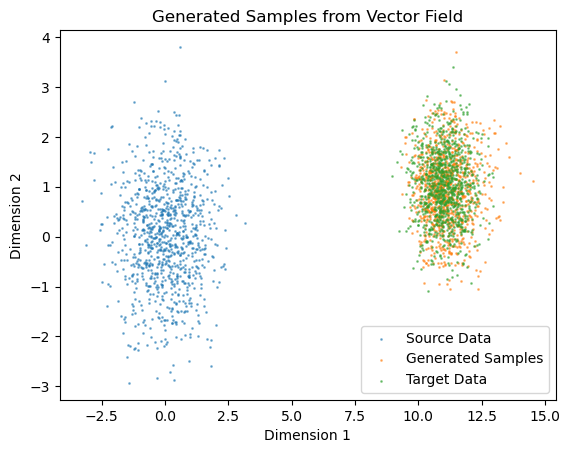

In [11]:
plt.scatter(source_data[:, 0], source_data[:, 1], s=1, alpha=0.5,label='Source Data')
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], s=1, alpha=0.5,label='Generated Samples')
plt.scatter(target_data[:, 0], target_data[:, 1], s=1, alpha=0.5,label='Target Data')
plt.legend()
plt.title('Generated Samples from Vector Field')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()